In [135]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os, glob, subprocess, random, time
from IPython.display import display, HTML
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import networkx as nx
try:
    print(open('README.md').read())
except:
    pass
print('-'*100)
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        if 'git' in str(root):
            continue
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
list_files('.')

def prints(txt):
    txt = str(txt)
    try:
        print(txt[:1000])
    except:
        pass
    #print(txt)


# LumPy
[![License: GPL v3](https://img.shields.io/badge/License-GPL%20v3-blue.svg)](http://www.gnu.org/licenses/gpl-3.0)
[![Build Status](https://travis-ci.org/gerritgr/LumPyQest.svg?branch=master)](https://travis-ci.org/gerritgr/LumPyQest)

Copyright: 2018, Gerrit Großmann, [Group of Modeling and Simulation](https://mosi.uni-saarland.de/) at [Saarland University](http://www.cs.uni-saarland.de/)

Version: 0.1 (Please note that this code is an experimental version in a very early development stage.)
## Overview
------------------
The LumPy toolset provides a proof of concept for lumping for AME equations for multistate processes on complex networks.
It reduces the large number of ODEs given by the equation systems by clustering them and only solving a single ODE per cluster.
LumPy is written in Python 3 (requiring SciPy) and published under GPL v3 license.

As input, the tool takes model descriptions (containing degree distribution, rules,
time horizon, etc.) and outputs the lumped (o

In [147]:
clustering_file = 'output/SIS/clustering_SIS_306.csv'
clustering_original_file = 'output/SISfull/clustering_SISfull_1326.csv'
dynamics_original_file = 'output/SISfull/ame_SISfull_1326_trajectories_individual.csv'
dynamics_reduced_file = 'output/SIS/ame_SIS_306_trajectories_individual.csv'  #73

clustering = pd.read_csv(clustering_file, skiprows=1, sep=';') 
clustering_original = pd.read_csv(clustering_original_file, skiprows=1, sep=';') 
dynamics_original = pd.read_csv(dynamics_original_file, skiprows=1, sep=';')  #open(dynamics_original_file).read()
dynamics_reduced = pd.read_csv(dynamics_reduced_file, skiprows=1, sep=';')  #open(dynamics_reduced_file).read()



In [66]:
clustering_original.head()

,m,cluster,weight
0,"(31, 6)","(37, (837.0, 162.0))",1.0
1,"(21, 28)","(49, (428.0, 571.0))",1.0
2,"(4, 36)","(40, (99.0, 900.0))",1.0
3,"(43, 3)","(46, (934.0, 65.0))",1.0
4,"(7, 25)","(32, (218.0, 781.0))",1.0


# Funtion m to cluster and vice versa

In [110]:
def get_cluster_maps(clustering):
    try:
        clustering = clustering.to_dict(orient='records')
    except: 
        pass
    
    m_to_cluster = dict()
    cluster_to_m = dict()
    m_to_weight = dict()
    for line in clustering:
        m = eval(line['m'])
        cluster = line['cluster']
        weight = line['weight']
        m_to_cluster[m] = cluster
        m_to_weight[m] = weight
        if cluster not in cluster_to_m:
            cluster_to_m[cluster] = list()
        cluster_to_m[cluster].append(m)
    return m_to_cluster, cluster_to_m, m_to_weight

# Plot Original

### 2652 ODEs and 1326 cluster

In [111]:
print(clustering_original.head())
m_to_cluster, cluster_to_m, m_to_weight = get_cluster_maps(clustering_original)
print(str(cluster_to_m)[:1000])

          m               cluster  weight
0   (31, 6)  (37, (837.0, 162.0))     1.0
1  (21, 28)  (49, (428.0, 571.0))     1.0
2   (4, 36)   (40, (99.0, 900.0))     1.0
3   (43, 3)   (46, (934.0, 65.0))     1.0
4   (7, 25)  (32, (218.0, 781.0))     1.0
{'(37, (837.0, 162.0))': [(31, 6)], '(49, (428.0, 571.0))': [(21, 28)], '(40, (99.0, 900.0))': [(4, 36)], '(46, (934.0, 65.0))': [(43, 3)], '(32, (218.0, 781.0))': [(7, 25)], '(9, (999.0, 0.0))': [(9, 0)], '(42, (809.0, 190.0))': [(34, 8)], '(45, (333.0, 666.0))': [(15, 30)], '(50, (739.0, 260.0))': [(37, 13)], '(38, (631.0, 368.0))': [(24, 14)], '(33, (393.0, 606.0))': [(13, 20)], '(5, (599.0, 400.0))': [(3, 2)], '(38, (736.0, 263.0))': [(28, 10)], '(46, (673.0, 326.0))': [(31, 15)], '(41, (24.0, 975.0))': [(1, 40)], '(39, (102.0, 897.0))': [(4, 35)], '(46, (173.0, 826.0))': [(8, 38)], '(29, (241.0, 758.0))': [(7, 22)], '(34, (647.0, 352.0))': [(22, 12)], '(18, (499.0, 500.0))': [(9, 9)], '(37, (918.0, 81.0))': [(34, 3)], '(45, (533.0, 4

In [112]:
dynamics_original.head()

,"('I', '(0, (0.0, 999.0))')","('I', '(1, (0.0, 999.0))')","('I', '(1, (999.0, 0.0))')","('I', '(10, (0.0, 999.0))')","('I', '(10, (199.0, 800.0))')","('I', '(10, (299.0, 700.0))')","('I', '(10, (399.0, 600.0))')","('I', '(10, (499.0, 500.0))')","('I', '(10, (599.0, 400.0))')","('I', '(10, (699.0, 300.0))')",...,"('S', '(9, (0.0, 999.0))')","('S', '(9, (111.0, 888.0))')","('S', '(9, (222.0, 777.0))')","('S', '(9, (333.0, 666.0))')","('S', '(9, (444.0, 555.0))')","('S', '(9, (555.0, 444.0))')","('S', '(9, (666.0, 333.0))')","('S', '(9, (777.0, 222.0))')","('S', '(9, (888.0, 111.0))')","('S', '(9, (999.0, 0.0))')"
0,7.464749e-11,0.067183,0.007465,8.230767e-05,0.000046,0.000014,0.000003,3.512597e-07,3.252405e-08,2.065019e-09,...,0.001071,0.001071,0.000476,0.000123,0.000021,0.000002,1.693005e-07,8.061929e-09,2.239425e-10,2.764722e-12
1,7.136282e-11,0.052267,0.030967,1.030474e-05,0.000160,0.000160,0.000100,4.285951e-05,1.274047e-05,2.611262e-06,...,0.000600,0.000889,0.000586,0.000227,0.000057,0.000010,1.097069e-06,8.416672e-08,4.013849e-09,9.346394e-11
2,6.822267e-11,0.041662,0.053330,2.126014e-06,0.000150,0.000227,0.000224,1.565866e-04,7.852179e-05,2.776193e-05,...,0.000340,0.000650,0.000555,0.000280,0.000093,0.000022,3.843804e-06,5.232218e-07,5.188697e-08,2.749108e-09
3,6.522070e-11,0.034487,0.074257,9.199038e-07,0.000120,0.000223,0.000284,2.652625e-04,1.841542e-04,9.230811e-05,...,0.000207,0.000460,0.000459,0.000273,0.000110,0.000033,8.451928e-06,1.857919e-06,3.054601e-07,2.578077e-08
4,6.235083e-11,0.029845,0.093532,5.771082e-07,0.000091,0.000193,0.000287,3.275440e-04,2.859434e-04,1.843058e-04,...,0.000136,0.000328,0.000358,0.000236,0.000108,0.000040,1.383653e-05,4.349116e-06,9.995462e-07,1.144244e-07


In [137]:
os.system('mkdir gif_out')

def plot_dyn(m_to_value, title='Original I Fraction', t=0.3):
    x_list = list()
    y_list = list()
    value_list = list()
    
    for m, value in m_to_value.items():
        x_list.append(m[0])
        y_list.append(m[1])
        value_list.append(value)
        
    value_list = [np.log(n+0.0000000001) for n in value_list]    
    plt.scatter(x_list, y_list, c=value_list, cmap='hot')
    plt.title(title)
    #plt.show()
    plt.savefig('gif_out/'+title.replace(' ','')+'.jpg')
    

{(0, 0): 7.464749463148459e-11, (0, 1): 0.06718274516833614, (1, 0): 0.007464749463148461, (0, 10): 8.230767434916922e-05, (2, 8): 4.572648574953849e-05, (3, 7): 1.3548588370233603e-05, (4, 6): 2.634447738656541e-06, (5, 5): 3.5125969848753935e-07, (6, 4): 3.252404615625367e-08, (7, 3): 2.065018803571661e-09, (8, 2): 8.604245014881892e-11, (9, 1): 2.124504941946136e-12, (1, 9): 9.14529714990768e-05, (10, 0): 2.3605610466068345e-14, (0, 11): 5.837153675187414e-05, (2, 9): 3.963499409077874e-05, (3, 8): 1.3211664696926233e-05, (4, 7): 2.9359254882058386e-06, (5, 6): 4.5669952038757497e-07, (6, 5): 5.074439115417505e-08, (7, 4): 4.027332631283742e-09, (8, 3): 2.2374070173798472e-10, (9, 2): 8.286692656962395e-12, (1, 10): 7.134298936340169e-05, (10, 1): 1.841487257102758e-13, (11, 0): 1.86008813848764e-15, (0, 12): 4.226415927827759e-05, (2, 10): 3.443746311563348e-05, (3, 9): 1.2754615968753155e-05, (4, 8): 3.1886539921882883e-06, (5, 7): 5.668718208334756e-07, (6, 6): 7.348338418211695e

{(0, 0): 4.978814792505544e-11, (0, 1): 0.02515036019591936, (1, 0): 0.16483980207475793, (0, 10): 9.977788006726176e-08, (2, 8): 1.9169246859870777e-05, (3, 7): 4.977041286994959e-05, (4, 6): 0.00010830028811126632, (5, 5): 0.00021386899793863215, (6, 4): 0.0003645573957992807, (7, 3): 0.0004908431096215709, (8, 2): 0.000473764601043245, (9, 1): 0.00028680405571900275, (1, 9): 4.4837756408780326e-06, (10, 0): 8.117241989433996e-05, (0, 11): 4.22421462903956e-08, (2, 9): 9.303612874284482e-06, (3, 8): 2.4458134373753212e-05, (4, 7): 5.3183124805289444e-05, (5, 6): 0.00010784346113553346, (6, 5): 0.0002003567739323825, (7, 4): 0.0003159058546880543, (8, 3): 0.00038911634349934144, (9, 2): 0.00034274077383880376, (1, 10): 2.0907557938255403e-06, (10, 1): 0.00018976660678686247, (11, 0): 4.93270066847846e-05, (0, 12): 1.852782951792412e-08, (2, 10): 4.6469080169556384e-06, (3, 9): 1.241531733070109e-05, (4, 8): 2.683962337937328e-05, (5, 7): 5.45246411942024e-05, (6, 6): 0.000106017038758

{(0, 0): 3.320754014470525e-11, (0, 1): 0.030697362564974327, (1, 0): 0.22351752590580057, (0, 10): 8.474993834804927e-09, (2, 8): 1.5475434046633444e-06, (3, 7): 3.6704274325908068e-06, (4, 6): 1.0576841909590109e-05, (5, 5): 3.820235285453129e-05, (6, 4): 0.00013069714056838163, (7, 3): 0.0003472556110353731, (8, 2): 0.0006388626096689023, (9, 1): 0.0007157561475910559, (1, 9): 4.7482911339402123e-07, (10, 0): 0.0003666931757186832, (0, 11): 3.08028616728183e-09, (2, 9): 6.271051507723738e-07, (3, 8): 1.37176589990406e-06, (4, 7): 3.3160221571841957e-06, (5, 6): 1.0974435183229978e-05, (6, 5): 4.0460168528611546e-05, (7, 4): 0.00012889192919275392, (8, 3): 0.00031054766352184055, (9, 2): 0.0005171968909674969, (1, 10): 1.9015918551978813e-07, (10, 1): 0.0005271910652704144, (11, 0): 0.0002473118207331827, (0, 12): 1.1624705233258567e-09, (2, 10): 2.649249434042639e-07, (3, 9): 5.56785377289764e-07, (4, 8): 1.157278567618936e-06, (5, 7): 3.2680065118819014e-06, (6, 6): 1.1965066173712

{(0, 0): 2.2148654497911028e-11, (0, 1): 0.03249663152359292, (1, 0): 0.244304060424749, (0, 10): 1.537071699500651e-09, (2, 8): 2.6031007784064547e-07, (3, 7): 6.781934087794866e-07, (4, 6): 3.0750160050404464e-06, (5, 5): 1.713433091382425e-05, (6, 4): 7.9274579730723e-05, (7, 3): 0.0002659937881815683, (8, 2): 0.0005993880766617732, (9, 1): 0.0008100108268949596, (1, 9): 9.526706137632577e-08, (10, 0): 0.0004961361583996873, (0, 11): 4.980785896075271e-10, (2, 9): 9.092557322901415e-08, (3, 8): 1.9420380795550968e-07, (4, 7): 6.82714141138966e-07, (5, 6): 3.770235160563762e-06, (6, 5): 1.9986979665781726e-05, (7, 4): 8.251560744058675e-05, (8, 3): 0.00024619226347456454, (9, 2): 0.0004972201241342423, (1, 10): 3.394515123915212e-08, (10, 1): 0.0006077942731623603, (11, 0): 0.0003395926002199095, (0, 12): 1.678650697193223e-10, (2, 10): 3.362858907657179e-08, (3, 9): 6.368982496225544e-08, (4, 8): 1.6797449408956318e-07, (5, 7): 8.242402233704123e-07, (6, 6): 4.724948789869375e-06, (

{(0, 0): 1.477263108149733e-11, (0, 1): 0.033024201951004764, (1, 0): 0.2523187740189378, (0, 10): 4.260003359218237e-10, (2, 8): 7.917845312982716e-08, (3, 7): 3.135420716207078e-07, (4, 6): 2.119379168048365e-06, (5, 5): 1.386606028691098e-05, (6, 4): 6.933844876384815e-05, (7, 3): 0.00024629190628693264, (8, 2): 0.0005838675741395896, (9, 1): 0.0008280461758252488, (1, 9): 2.7389090462442528e-08, (10, 0): 0.000531599169138352, (0, 11): 1.2230188290046785e-10, (2, 9): 2.3006526237866e-08, (3, 8): 6.850052292535567e-08, (4, 7): 4.0562507190271904e-07, (5, 6): 2.8581636540603038e-06, (6, 5): 1.6694955709084676e-05, (7, 4): 7.323457409351009e-05, (8, 3): 0.00022997849412634679, (9, 2): 0.00048732022641314617, (1, 10): 8.632830518191024e-09, (10, 1): 0.0006241209198410119, (11, 0): 0.00036507688737453007, (0, 12): 3.672484514748738e-11, (2, 10): 7.277019763810711e-09, (3, 9): 1.7124815950594686e-08, (4, 8): 8.067849412288053e-08, (5, 7): 5.739561720749738e-07, (6, 6): 3.7600797172167725e

{(0, 0): 9.852996715667726e-12, (0, 1): 0.033363656323904124, (1, 0): 0.25627258837020894, (0, 10): 1.5062313859673487e-10, (2, 8): 3.77915154990317e-08, (3, 7): 2.3637870850031523e-07, (4, 6): 1.91519674246561e-06, (5, 5): 1.3118317790559363e-05, (6, 4): 6.691053360325778e-05, (7, 3): 0.00024117935072573676, (8, 2): 0.0005794316551718748, (9, 1): 0.0008324173247644998, (1, 9): 9.829981278003388e-09, (10, 0): 0.0005412257111827704, (0, 11): 3.7573736797204806e-11, (2, 9): 8.87918318797559e-09, (3, 8): 4.425473314863537e-08, (4, 7): 3.514141795003865e-07, (5, 6): 2.6618168162180107e-06, (6, 5): 1.592345858636688e-05, (7, 4): 7.091958004810426e-05, (8, 3): 0.00022569173920873383, (9, 2): 0.0004843765676137298, (1, 10): 2.688199729428645e-09, (10, 1): 0.0006281804983391627, (11, 0): 0.0003720488037571255, (0, 12): 9.899582434685235e-12, (2, 10): 2.307210340239773e-09, (3, 9): 8.995532194066888e-09, (4, 8): 6.529777077091873e-08, (5, 7): 5.240480026491085e-07, (6, 6): 3.5437172034451708e-0

{(0, 0): 6.571716652442837e-12, (0, 1): 0.033665562016826404, (1, 0): 0.2589194796274164, (0, 10): 6.60703036757064e-11, (2, 8): 2.550588421461928e-08, (3, 7): 2.145740306306765e-07, (4, 6): 1.8604470913795665e-06, (5, 5): 1.2922644344608271e-05, (6, 4): 6.627622235286756e-05, (7, 3): 0.0002398358109080486, (8, 2): 0.000578254066344046, (9, 1): 0.0008335730294567261, (1, 9): 4.3589100708645744e-09, (10, 0): 0.0005438036774340674, (0, 11): 1.4069790327321215e-11, (2, 9): 5.073041265679536e-09, (3, 8): 3.792117987183367e-08, (4, 7): 3.3749946326041224e-07, (5, 6): 2.611403844948024e-06, (6, 5): 1.5723752301692203e-05, (7, 4): 7.031464701958245e-05, (8, 3): 0.00022455939861088092, (9, 2): 0.0004835822691100752, (1, 10): 1.0166042582500315e-09, (10, 1): 0.0006292434313163108, (11, 0): 0.00037391163045034714, (0, 12): 3.188901028496691e-12, (2, 10): 1.0973851329152797e-09, (3, 9): 7.060077931992093e-09, (4, 8): 6.159913973858341e-08, (5, 7): 5.1158838718997e-07, (6, 6): 3.4883029344318656e-

{(0, 0): 4.383180782210534e-12, (0, 1): 0.0339495989454461, (1, 0): 0.2610690642893659, (0, 10): 3.8019890523768395e-11, (2, 8): 2.1482773999774162e-08, (3, 7): 2.078760390517731e-07, (4, 6): 1.8465297531625169e-06, (5, 5): 1.2882142499846048e-05, (6, 4): 6.615909933743956e-05, (7, 3): 0.00023960329935547494, (8, 2): 0.0005780688766005375, (9, 1): 0.0008338037515519702, (1, 9): 2.535519432126417e-09, (10, 0): 0.0005442662013180693, (0, 11): 7.060509743931738e-12, (2, 9): 3.945475707160832e-09, (3, 8): 3.610280988452977e-08, (4, 7): 3.3399271650387406e-07, (5, 6): 2.6009352889278815e-06, (6, 5): 1.5686827835268538e-05, (7, 4): 7.020872874250468e-05, (8, 3): 0.00022436751545608442, (9, 2): 0.0004834551835736285, (1, 10): 5.160867773679178e-10, (10, 1): 0.0006294347888519275, (11, 0): 0.00037423266418939934, (0, 12): 1.3919284312427618e-12, (2, 10): 7.744853001177157e-10, (3, 9): 6.549134497160177e-09, (4, 8): 6.068883072241598e-08, (5, 7): 5.08977026609208e-07, (6, 6): 3.477996278084781e

{(0, 0): 2.923479115948329e-12, (0, 1): 0.034218557041012336, (1, 0): 0.262962192476874, (0, 10): 2.852732155372785e-11, (2, 8): 2.0143558695309725e-08, (3, 7): 2.0605094533940248e-07, (4, 6): 1.845964458251956e-06, (5, 5): 1.2893329663163714e-05, (6, 4): 6.621621540777848e-05, (7, 3): 0.00023974800668578853, (8, 2): 0.0005782242399296451, (9, 1): 0.0008337238191943037, (1, 9): 1.917127855512128e-09, (10, 0): 0.0005440080412014176, (0, 11): 4.931592024919919e-12, (2, 9): 3.6044586962747038e-09, (3, 8): 3.561671258162068e-08, (4, 7): 3.337086606805683e-07, (5, 6): 2.603518332235395e-06, (6, 5): 1.57044091102429e-05, (7, 4): 7.02717429038929e-05, (8, 3): 0.00022449643256667622, (9, 2): 0.0004835588164418307, (1, 10): 3.6380320505435593e-10, (10, 1): 0.0006293323166048406, (11, 0): 0.00037402729588584125, (0, 12): 9.025643696148309e-13, (2, 10): 6.862208238210574e-10, (3, 9): 6.4184033438562925e-09, (4, 8): 6.057810748471706e-08, (5, 7): 5.094899677702254e-07, (6, 6): 3.482673674995066e-0

{(0, 0): 1.9498919631864373e-12, (0, 1): 0.03447247924419909, (1, 0): 0.264677811706072, (0, 10): 2.5310703762419343e-11, (2, 8): 1.9716533890125957e-08, (3, 7): 2.0592649504426045e-07, (4, 6): 1.85033903815232e-06, (5, 5): 1.2924376447823145e-05, (6, 4): 6.63411552298464e-05, (7, 3): 0.00024004026930868837, (8, 2): 0.0005785135875423411, (9, 1): 0.0008335240619388827, (1, 9): 1.7066835360408704e-09, (10, 0): 0.0005434695755129715, (0, 11): 4.282320385959299e-12, (2, 9): 3.50357405961905e-09, (3, 8): 3.555238248316313e-08, (4, 7): 3.34552578104847e-07, (5, 6): 2.6110405342972763e-06, (6, 5): 1.5743149745150265e-05, (7, 4): 7.040080770754877e-05, (8, 3): 0.00022475109984736012, (9, 2): 0.00048375326230300686, (1, 10): 3.1718240169674805e-10, (10, 1): 0.0006291156214879936, (11, 0): 0.00037361660159339257, (0, 12): 7.68404445663801e-13, (2, 10): 6.621898763499846e-10, (3, 9): 6.395899019647252e-09, (4, 8): 6.072718113538734e-08, (5, 7): 5.111599474835734e-07, (6, 6): 3.4931507787855437e-

{(0, 0): 1.3005632449329894e-12, (0, 1): 0.03471095987631661, (1, 0): 0.26624707924838725, (0, 10): 2.4226675374344903e-11, (2, 8): 1.9604381633729686e-08, (3, 7): 2.064215715694328e-07, (4, 6): 1.85667416404331e-06, (5, 5): 1.2963632712697411e-05, (6, 4): 6.649436228062112e-05, (7, 3): 0.0002403939703983404, (8, 2): 0.0005788585372983088, (9, 1): 0.0008332747751789271, (1, 9): 1.6347962607365798e-09, (10, 0): 0.000542815743857008, (0, 11): 4.082997831732601e-12, (2, 9): 3.477056465392956e-09, (3, 8): 3.5628001641201e-08, (4, 7): 3.358260211846688e-07, (5, 6): 2.620593684759746e-06, (6, 5): 1.5790735774450725e-05, (7, 4): 7.055748461797227e-05, (8, 3): 0.00022505812133398175, (9, 2): 0.00048398520721354806, (1, 10): 3.026745557874764e-10, (10, 1): 0.0006288513860925864, (11, 0): 0.0003731211893569446, (0, 12): 7.30888331638432e-13, (2, 10): 6.559863268140411e-10, (3, 9): 6.405849130213412e-09, (4, 8): 6.097000149645101e-08, (5, 7): 5.133022251982545e-07, (6, 6): 3.506061857452934e-06, 

{(0, 0): 8.676243879835958e-13, (0, 1): 0.034933675804805726, (1, 0): 0.2676857130879475, (0, 10): 2.386756267018612e-11, (2, 8): 1.9601749945751244e-08, (3, 7): 2.0714260493022176e-07, (4, 6): 1.8637477648077966e-06, (5, 5): 1.3005947800784995e-05, (6, 4): 6.66578724233874e-05, (7, 3): 0.00024076954448007528, (8, 2): 0.000579222540909022, (9, 1): 0.0008330072693130025, (1, 9): 1.6099860887686758e-09, (10, 0): 0.0005421216629575971, (0, 11): 4.020700046564308e-12, (2, 9): 3.473901450677876e-09, (3, 8): 3.575127402863938e-08, (4, 7): 3.372593286111407e-07, (5, 6): 2.630911662213175e-06, (6, 5): 1.584159171444678e-05, (7, 4): 7.072415296218422e-05, (8, 3): 0.00022538365685519546, (9, 2): 0.00048422983219916844, (1, 10): 2.979417206022889e-10, (10, 1): 0.0006285699178452184, (11, 0): 0.000372596357077912, (0, 12): 7.197462774885424e-13, (2, 10): 6.548398701041606e-10, (3, 9): 6.42607322375941e-09, (4, 8): 6.124726732712204e-08, (5, 7): 5.156248893147066e-07, (6, 6): 3.5198874454591364e-06

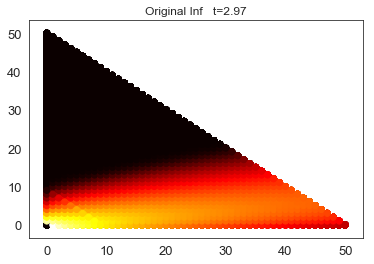

In [139]:
for timepoint in list(range(101)):
    dynamics_original   #101 rows × 2652 columns
    dyn_o =  dynamics_original.to_dict(orient='records')
    dyn_line = dyn_o[timepoint]
    m_to_value = dict()
    for cluster, value in dyn_line.items():
        if 'S' in cluster:
            continue
        cluster = cluster.replace("('I', '", "").replace("')","")
        mlist = cluster_to_m[cluster]
        for m in mlist:   # do weights
            m_to_value[m] = value
    prints(m_to_value) 

    real_time = str(timepoint/101.0*3) + '00000000000000000000'
    real_time = real_time[:4]
    plot_dyn(m_to_value, 'Original Inf   t='+real_time, timepoint/101.0*3)

# Plot Reduced 

{'(20, (18.0, 3.0))': [(31, 6), (32, 6), (30, 6), (32, 7), (34, 6), (35, 7), (34, 7), (29, 6), (35, 6), (30, 5), (31, 5), (36, 6), (33, 7), (33, 6)], '(21, (9.0, 12.0))': [(21, 28), (20, 24), (21, 27), (20, 25), (21, 26), (22, 28), (18, 25), (20, 26), (19, 25), (20, 28), (20, 27), (22, 27), (19, 24), (19, 27), (21, 29), (19, 26)], '(20, (2.0, 19.0))': [(4, 36), (4, 35), (5, 32), (4, 37), (4, 38), (5, 37), (5, 36), (4, 32), (5, 35), (4, 33), (5, 34), (4, 34), (4, 31), (5, 33)], '(21, (20.0, 1.0))': [(43, 3), (42, 2), (46, 3), (45, 4), (42, 3), (45, 3), (43, 4), (41, 3), (41, 4), (41, 2), (44, 4), (44, 3), (42, 4), (46, 4), (40, 3), (47, 3)], '(19, (4.0, 17.0))': [(7, 25), (7, 24), (7, 27), (6, 26), (7, 26), (6, 25)], '(8, (21.0, 0.0))': [(9, 0)], '(20, (17.0, 4.0))': [(34, 8), (32, 8), (29, 8), (32, 9), (30, 7), (31, 9), (29, 7), (33, 9), (31, 8), (33, 8), (28, 8), (28, 7), (31, 7), (30, 8)], '(21, (7.0, 14.0))': [(15, 30), (16, 29), (17, 30), (18, 32), (16, 32), (16, 30), (15, 32), (16

{(0, 0): 4.951197817709953e-11, (0, 1): 0.02475598908854976, (1, 0): 0.15845873511459463, (0, 2): 0.0019864039514093466, (1, 1): 0.02223801740660136, (2, 0): 0.02684405312849187, (0, 11): 4.808223503207408e-08, (1, 10): 2.346037575321773e-06, (6, 5): 0.00022709438919228466, (7, 4): 0.00032923606382666244, (8, 3): 0.00037139016477523944, (9, 2): 0.0002994489730587743, (10, 1): 0.00015186741647634205, (11, 0): 3.61896094424538e-05, (2, 9): 1.1212786078996182e-05, (3, 8): 3.087552574596521e-05, (4, 7): 6.740287270537937e-05, (5, 6): 0.0001311973824265527, (0, 12): 2.107119173214572e-08, (1, 11): 1.1220174442043551e-06, (6, 6): 0.00012753443243424594, (7, 5): 0.00020647617703729463, (8, 4): 0.0002767638429878131, (9, 3): 0.00028705182896527796, (10, 2): 0.00021273719185143546, (11, 1): 9.941548004708011e-05, (12, 0): 2.1909929176768483e-05, (2, 10): 5.615860120979628e-06, (3, 9): 1.5881681443668606e-05, (4, 8): 3.506545710222262e-05, (5, 7): 6.960216627322418e-05, (0, 14): 5.84790489714019

{(0, 0): 6.196266728540489e-11, (0, 1): 0.030981333642702443, (1, 0): 0.2272553803084213, (0, 2): 0.0018180039360059122, (1, 1): 0.02278444793927992, (2, 0): 0.0481754520199983, (0, 11): 2.861705993848455e-09, (1, 10): 1.7513067018422842e-07, (6, 5): 4.328626466888419e-05, (7, 4): 0.000134662600462942, (8, 3): 0.0003173923920632927, (9, 2): 0.0005179810695985866, (10, 1): 0.0005180446337578582, (11, 0): 0.00023866519929483058, (2, 9): 6.237138990959618e-07, (3, 8): 1.451141214862763e-06, (4, 7): 3.633013298130948e-06, (5, 6): 1.199674351359235e-05, (0, 12): 1.0575225330723434e-09, (1, 11): 7.071556800821955e-08, (6, 6): 1.3042193236740535e-05, (7, 5): 4.5693531116023073e-05, (8, 4): 0.0001311048935288026, (9, 3): 0.0002816905097881336, (10, 2): 0.00041964255028010096, (11, 1): 0.00038499110993214786, (12, 0): 0.0001636080049560992, (2, 10): 2.584765967714152e-07, (3, 9): 5.797652008618347e-07, (4, 8): 1.2625877939114168e-06, (5, 7): 3.617269778774285e-06, (0, 14): 2.303082189608815e-10

{(0, 0): 6.650839025747025e-11, (0, 1): 0.03325419512873513, (1, 0): 0.2507468236558141, (0, 2): 0.001578556290055206, (1, 1): 0.02165504577430444, (2, 0): 0.05756317709197065, (0, 11): 4.12435875463765e-10, (1, 10): 2.8061597684344607e-08, (6, 5): 2.001662624431628e-05, (7, 4): 8.265575431453236e-05, (8, 3): 0.000246483021429367, (9, 2): 0.0004974718247279438, (10, 1): 0.0006076749569224837, (11, 0): 0.00033928933771873156, (2, 9): 7.948021363306256e-08, (3, 8): 1.7982013012621352e-07, (4, 7): 6.672244894683301e-07, (5, 6): 3.761309497007031e-06, (0, 12): 1.3518012043998084e-10, (1, 11): 1.003223042728512e-08, (6, 6): 4.726567497393587e-06, (7, 5): 2.2898943479081587e-05, (8, 4): 8.455584188291996e-05, (9, 3): 0.00022644886366051176, (10, 2): 0.00041377011510235174, (11, 1): 0.00046125876445800236, (12, 0): 0.0002367279082996579, (2, 10): 2.8561491897876078e-08, (3, 9): 5.704553929520475e-08, (4, 8): 1.6027987618307622e-07, (5, 7): 8.169349290974488e-07, (0, 14): 2.4832988133261843e-1

{(0, 0): 6.772886686523539e-11, (0, 1): 0.03386443343261769, (1, 0): 0.2594634850119546, (0, 2): 0.0015084168016252031, (1, 1): 0.02145983143703124, (2, 0): 0.0618182606625073, (0, 11): 9.359775283658577e-11, (1, 10): 6.6121805190989745e-09, (6, 5): 1.6522007599416917e-05, (7, 4): 7.272693053339142e-05, (8, 3): 0.00022905478625138585, (9, 2): 0.0004867090062978832, (10, 1): 0.0006250266182860785, (11, 0): 0.00036658552759631267, (2, 9): 1.8794642091663512e-08, (3, 8): 6.193024457358208e-08, (4, 7): 3.9207213698586076e-07, (5, 6): 2.812378874121689e-06, (0, 12): 2.7118672362938973e-11, (1, 11): 2.0868767304459552e-09, (6, 6): 3.7097704183171326e-06, (7, 5): 1.92820991899576e-05, (8, 4): 7.527017178928931e-05, (9, 3): 0.0002121879245604024, (10, 2): 0.0004074347690422041, (11, 1): 0.00047690344372844357, (12, 0): 0.000256863438412982, (2, 10): 5.6920946182320105e-09, (3, 9): 1.4748234905505932e-08, (4, 8): 7.651418085323407e-08, (5, 7): 5.616187584998081e-07, (0, 14): 4.208797793037942e-

{(0, 0): 6.845079822493625e-11, (0, 1): 0.03422539911246812, (1, 0): 0.26360942813414234, (0, 2): 0.001506989782244179, (1, 1): 0.02166439623834281, (2, 0): 0.06417351646578258, (0, 11): 2.7480907511084574e-11, (1, 10): 1.970763784484727e-09, (6, 5): 1.5738527358594684e-05, (7, 4): 7.034785667246847e-05, (8, 3): 0.00022461273660183043, (9, 2): 0.0004836066761232235, (10, 1): 0.0006291649701516616, (11, 0): 0.00037380100895619835, (2, 9): 7.303931027055575e-09, (3, 8): 4.127846412658677e-08, (4, 7): 3.421161203989907e-07, (5, 6): 2.6185919263917794e-06, (0, 12): 6.908243154643509e-12, (1, 11): 5.389248438705774e-10, (6, 6): 3.491822243971638e-06, (7, 5): 1.844485403242264e-05, (8, 4): 7.299401621854632e-05, (9, 3): 0.00020848006895293468, (10, 2): 0.00040550234439044744, (11, 1): 0.00048074774624493885, (12, 0): 0.0002622512204765285, (2, 10): 1.7911137125781406e-09, (3, 9): 8.103328335054523e-09, (4, 8): 6.296546475782797e-08, (5, 7): 5.134612234377169e-07, (0, 14): 8.929196972380543e-

{(0, 0): 6.907775756972259e-11, (0, 1): 0.034538878784861296, (1, 0): 0.26633095391499856, (0, 2): 0.001522936178556647, (1, 1): 0.021942995515323714, (2, 0): 0.06574472511896937, (0, 11): 1.0398838698894424e-11, (1, 10): 7.548658927565204e-10, (6, 5): 1.5545839592457032e-05, (7, 4): 6.975679869241788e-05, (8, 3): 0.0002234967846430238, (9, 2): 0.0004828099858488332, (10, 1): 0.0006301937162036454, (11, 0): 0.0003756338024733732, (2, 9): 4.4300646210303695e-09, (3, 8): 3.6266288669747536e-08, (4, 7): 3.300810907405757e-07, (5, 6): 2.5714524529750715e-06, (0, 12): 2.227307921977605e-12, (1, 11): 1.7571948956415943e-10, (6, 6): 3.4387014496879816e-06, (7, 5): 1.823797169620016e-05, (8, 4): 7.24255580834789e-05, (9, 3): 0.00020754297867419343, (10, 2): 0.00040499870034813495, (11, 1): 0.0004817082552928933, (12, 0): 0.0002636240761846001, (2, 10): 9.145248214297219e-10, (3, 9): 6.640111992806785e-09, (4, 8): 5.990850694626583e-08, (5, 7): 5.02040804753052e-07, (0, 14): 2.3769926101459886e

{(0, 0): 6.966326636021988e-11, (0, 1): 0.03483163318010994, (1, 0): 0.2685276492288549, (0, 2): 0.0015409882357071446, (1, 1): 0.022199916227050257, (2, 0): 0.06690104775967373, (0, 11): 5.633895256865834e-12, (1, 10): 4.1430454601732786e-10, (6, 5): 1.551528571943643e-05, (7, 4): 6.966888740700793e-05, (8, 3): 0.0002233372284534269, (9, 2): 0.0004827034125483418, (10, 1): 0.0006303509813891544, (11, 0): 0.0003758997537111557, (2, 9): 3.6339564104848483e-09, (3, 8): 3.4930809921182614e-08, (4, 7): 3.273547136651998e-07, (5, 6): 2.5629221402278314e-06, (0, 12): 1.0618896969910183e-12, (1, 11): 8.495932947732392e-11, (6, 6): 3.4301865291185507e-06, (7, 5): 1.820698376206744e-05, (8, 4): 7.23433741334483e-05, (9, 3): 0.0002074107937615712, (10, 2): 0.0004049313828334272, (11, 1): 0.0004818484432117285, (12, 0): 0.00026381932359534213, (2, 10): 6.967949462764861e-10, (3, 9): 6.281001230967347e-09, (4, 8): 5.9224047311397376e-08, (5, 7): 4.999367925002406e-07, (0, 14): 9.923273848604835e-1

{(0, 0): 7.021542010652662e-11, (0, 1): 0.035107710053263304, (1, 0): 0.27045864534281966, (0, 2): 0.001557385276197923, (1, 1): 0.022416805607625392, (2, 0): 0.06778626660271485, (0, 11): 4.2770081647350734e-12, (1, 10): 3.1709721095090564e-10, (6, 5): 1.553682254388029e-05, (7, 4): 6.974426448977646e-05, (8, 3): 0.00022349019805453335, (9, 2): 0.000482825097531486, (10, 1): 0.0006302264902521642, (11, 0): 0.00037565320196190476, (2, 9): 3.408630530491802e-09, (3, 8): 3.4617670377125253e-08, (4, 7): 3.273864564646107e-07, (5, 6): 2.5665097091551543e-06, (0, 12): 7.659036390508371e-13, (1, 11): 6.186228663852656e-11, (6, 6): 3.435918077651194e-06, (7, 5): 1.823297207121074e-05, (8, 4): 7.241979049142605e-05, (9, 3): 0.0002075426147799257, (10, 2): 0.0004050091433954868, (11, 1): 0.00048172161531172703, (12, 0): 0.0002636280465240104, (2, 10): 6.411622261616796e-10, (3, 9): 6.198313771438819e-09, (4, 8): 5.91925797671359e-08, (5, 7): 5.006858471449168e-07, (0, 14): 6.938356058464814e-14

{(0, 0): 7.073487185480583e-11, (0, 1): 0.035367435927402914, (1, 0): 0.2722060963958407, (0, 2): 0.001571501456553497, (1, 1): 0.022595606157029054, (2, 0): 0.06847413908066836, (0, 11): 3.886770242656416e-12, (1, 10): 2.8895372351368814e-10, (6, 5): 1.5577640815295914e-05, (7, 4): 6.988037924988389e-05, (8, 3): 0.00022375953799692007, (9, 2): 0.000483031880521074, (10, 1): 0.0006299976406496952, (11, 0): 0.0003752166902548549, (2, 9): 3.3468559994246067e-09, (3, 8): 3.461230912384485e-08, (4, 7): 3.283486313386915e-07, (5, 6): 2.5744915658663905e-06, (0, 12): 6.895028060008039e-13, (1, 11): 5.586106061428138e-11, (6, 6): 3.4469189214717757e-06, (7, 5): 1.828018998091072e-05, (8, 4): 7.255536290132755e-05, (9, 3): 0.0002077728418911865, (10, 2): 0.00040514089210485056, (11, 1): 0.00048149542553170945, (12, 0): 0.0002632931790828843, (2, 10): 6.269474825117596e-10, (3, 9): 6.1903047449146324e-09, (4, 8): 5.936750116966411e-08, (5, 7): 5.02453920759327e-07, (0, 14): 6.275897401549171e-1

{(0, 0): 7.122104455028164e-11, (0, 1): 0.03561052227514082, (1, 0): 0.27380167687544227, (0, 2): 0.0015834827112714812, (1, 1): 0.022742290500986, (2, 0): 0.06901218840474496, (0, 11): 3.771909637883524e-12, (1, 10): 2.8047345560763974e-10, (6, 5): 1.562600092596106e-05, (7, 4): 7.004015077040361e-05, (8, 3): 0.00022407387847224526, (9, 2): 0.0004832711194199882, (10, 1): 0.0006297282356652502, (11, 0): 0.00037470740395200764, (2, 9): 3.3328804180298266e-09, (3, 8): 3.470509626734105e-08, (4, 7): 3.296514862339112e-07, (5, 6): 2.5841795028849285e-06, (0, 12): 6.687651156601411e-13, (1, 11): 5.4190761925087754e-11, (6, 6): 3.459994356337748e-06, (7, 5): 1.8335734180144454e-05, (8, 4): 7.271397459802157e-05, (9, 3): 0.00020804106522882062, (10, 2): 0.0004052930542175849, (11, 1): 0.0004812306089629887, (12, 0): 0.00026290326727577414, (2, 10): 6.235454140110027e-10, (3, 9): 6.20394257611556e-09, (4, 8): 5.961517001746847e-08, (5, 7): 5.046175243345927e-07, (0, 14): 6.112379435073882e-14

{(0, 0): 7.167353381273318e-11, (0, 1): 0.03583676690636659, (1, 0): 0.27526145685472553, (0, 2): 0.0015936260136089765, (1, 1): 0.022862781753302343, (2, 0): 0.0694347946668085, (0, 11): 3.736073952355984e-12, (1, 10): 2.7763746320507015e-10, (6, 5): 1.5676728328579254e-05, (7, 4): 7.020707287217352e-05, (8, 3): 0.00022440131554467754, (9, 2): 0.00048351912847283894, (10, 1): 0.0006294464953900112, (11, 0): 0.00037417748106005237, (2, 9): 3.333234600020252e-09, (3, 8): 3.482990082723602e-08, (4, 7): 3.3107013183291366e-07, (5, 6): 2.594426954261152e-06, (0, 12): 6.623099080463391e-13, (1, 11): 5.36322754830568e-11, (6, 6): 3.4737376514846894e-06, (7, 5): 1.8393855832700354e-05, (8, 4): 7.287947673379048e-05, (9, 3): 0.00020832023384807424, (10, 2): 0.00040545054888302856, (11, 1): 0.0004809542500997951, (12, 0): 0.000262497845478153, (2, 10): 6.230860716309116e-10, (3, 9): 6.224296463141655e-09, (4, 8): 5.988786201916114e-08, (5, 7): 5.069144654801399e-07, (0, 14): 6.058864320390957e-

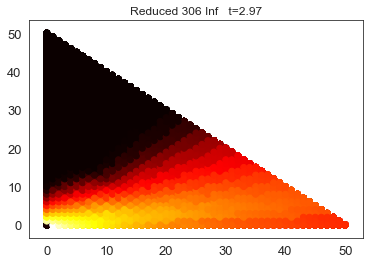

In [148]:
m_to_cluster, cluster_to_m, m_to_weight = get_cluster_maps(clustering)
prints(cluster_to_m)

for timepoint in list(range(101)):
    dynamics_reduced   #101 rows × 2652 columns
    dyn_o =  dynamics_reduced.to_dict(orient='records')
    dyn_line = dyn_o[timepoint]
    m_to_value = dict()
    for cluster, value in dyn_line.items():
        if 'S' in cluster:
            continue
        cluster = cluster.replace("('I', '", "").replace("')","")
        mlist = cluster_to_m[cluster]
        for m in mlist:   # do weights
            m_to_value[m] = value * m_to_weight[m]
    prints(m_to_value) 

    real_time = str(timepoint/101.0*3) + '00000000000000000000'
    real_time = real_time[:4]
    plot_dyn(m_to_value, 'Reduced 306 Inf   t='+real_time, timepoint/101.0*3)